# Introduction

In this notebook, we apply Moran’s I to quantify the spatial autocorrelation. We then use folium map to see the spatial clusters, which highlight neighborhoods based on their eviction patterns: top 20%, above median, low eviction/mode. The viz offers a clear view of how eviction rates are geographically distributed.

Then, we used queen and rook methods. Both methods' moran's I are around 0.84, indicating a strong positive spatial autocorrelation. The p-values in both cases are also 0.001, further confirming the statistical significance of the spatial clustering pattern. Therefore, safe to conclude eviction data in nyc are geographically concentrated,

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

# sklearn stuff
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from shapely.geometry import Point
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

# Part 1: Get the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data source:
# already cleaned gdf
file_path = '/content/drive/My Drive/X999/evictions_cleaned.csv'

In [ ]:
evictions_cleaned_raw = pd.read_csv(file_path)

In [ ]:
evictions_cleaned = evictions_cleaned_raw.copy()
# easier to work around with a copy

# Part 4: Clustering Analysis

## Part 4.1 Moran's I analysis:

- Moran’s I Value: it ranges from -1 (perfect dispersion) to +1 (perfect clustering), with 0 indicating random spatial distribution.
- p-value: indicates the statistical significance of the result. A low p-value (here we want < 0.05) suggests that the observed spatial pattern is unlikely to have occurred by chance.
- only using DCSCAN clusters for later analysis

source: https://www.statisticshowto.com/morans-i/

In [ ]:
evictions_cleaned.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
       'same_cluster'],
      dtype='object')

In [ ]:
# re-touch the data for further analysis
k = 3 # as decided by DBSCAN
evictions_cleaned['latitude'] = evictions_cleaned['latitude'].astype(float)
evictions_cleaned['longitude'] = evictions_cleaned['longitude'].astype(float)
evictions_cleaned['geometry'] = evictions_cleaned.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
# gdf = gpd.GeoDataFrame(evictions_cleaned, geometry='geometry')


In [ ]:
# using the weight, w, from above
# moran's I for the average_year_eviction_count column
# moran's I value and p-value
# it suggests strong correlation with fairly good confidence
attribute = evictions_cleaned['average_year_eviction_count'].values
moran = Moran(attribute, w)
print("results: moran's I:", moran.I, "p-value:", moran.p_sim)

results: moran's I: 0.9809436150054953 p-value: 0.001


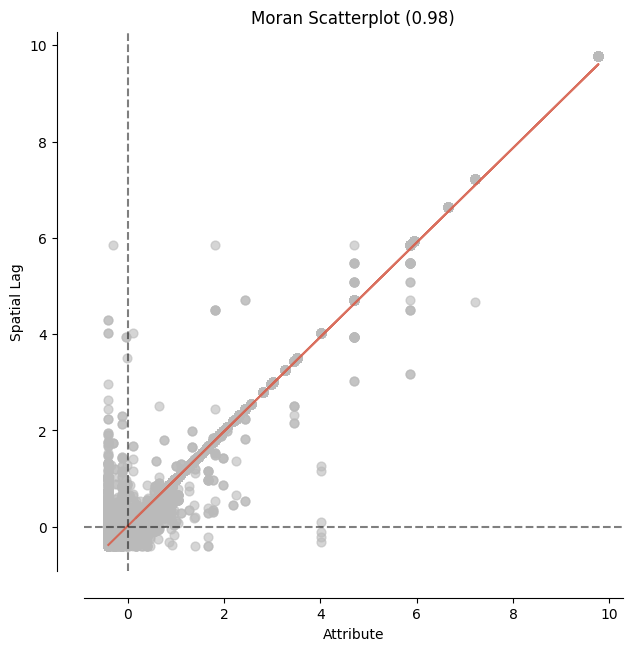

In [ ]:
fig, ax = moran_scatterplot(moran)
plt.show()

#### short summaries: what do these Moran results mean?

- The Moran's I value of 0.98 and a p-value of 0.001 indicate a strong positive spatial autocorrelation. This suggests that areas with high eviction counts are likely to be surrounded by other areas with high eviction counts, and similarly for areas with low eviction counts.

#### running on Folium again to visualize everything on a map

In [ ]:
threshold_80_percentile = evictions_cleaned['average_year_eviction_count'].quantile(0.80)
# top_20_percent_evictions = evictions_cleaned[evictions_cleaned['average_year_eviction_count'] >= threshold_80_percentile]
threshold_median = evictions_cleaned['average_year_eviction_count'].median()
threshold_mode = evictions_cleaned['average_year_eviction_count'].mode()
threshold_low = evictions_cleaned['average_year_eviction_count'].min()

In [ ]:
threshold_80_percentile

2.6666666666666665

In [ ]:
threshold_mode

,average_year_eviction_count
0,1.0


In [ ]:
threshold_median

1.5

In [ ]:
threshold_low

1.0

In [ ]:
map_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for idx, row in evictions_cleaned.iterrows():
    eviction_count = row['average_year_eviction_count']
    if eviction_count > threshold_80_percentile:
        color = 'red'
        popup_info = f"top 20 percent evictions area: {eviction_count}"
    elif eviction_count >= threshold_median:
        color = 'yellow'
        popup_info = f"above median eviction area: {eviction_count}"
    else:
        color = 'greeen'
        popup_info = f"low eviction/most commen: {eviction_count}"

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=popup_info
    ).add_to(map_clusters)

map_clusters

Saving nyc_cluster_moran_scores.png to nyc_cluster_moran_scores.png


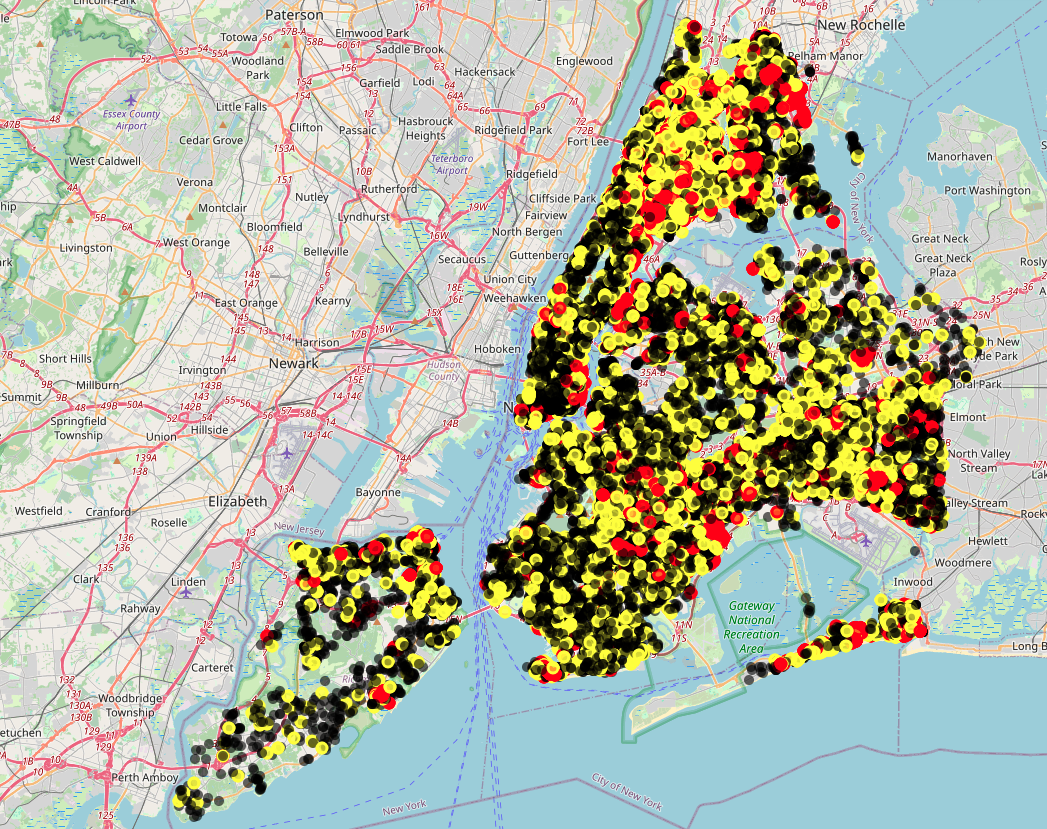

In [ ]:
# in case it does not load, it is as shown below
# the interactive map is too large to be uploaded
# so here is a screenshot of what it looks like
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='nyc_cluster_moran_scores.png')

In [ ]:
map_clusters.save('eviction_clusters_map.html')

## Part 4.2: Queen and Rook Contiguity

These two methods are usually used to evaluate autocorrelations in geo data. 
- queen contiguity: neighbors are considered adjacent if they share any boundary. edge or corner.
- rook contiguity: neighbors are considered adjacent only if they share a common edge





In [ ]:
w_queen = Queen.from_dataframe(evictions_cleaned)
w_rook = Rook.from_dataframe(evictions_cleaned)

In [ ]:
w_queen, w_rook

(<libpysal.weights.contiguity.Queen at 0x78c89901d480>,
 <libpysal.weights.contiguity.Rook at 0x78c88af64100>)

In [ ]:
# log did not work well with the previous data with DBSCAN algo, and therefore we will skip it here too
# but what log-transform does to the eviction count is to normalize the data better but it is not always necessary
# adding 1 to avoid log(0)
# evictions_cleaned['average_year_eviction_count_log'] = np.log1p(evictions_cleaned['average_year_eviction_count'])

In [ ]:
# still very good results
# use "average_year_eviction_count" column's values
attribute = evictions_cleaned['average_year_eviction_count'].values
moran_queen = Moran(attribute, w_queen)
print("moran's I with queen test:", moran_queen.I, "p-value:", moran_queen.p_sim)

moran's I with queen test: 0.8437983772474493 p-value: 0.001


In [ ]:
# moran's I using Rook Contiguity
# also very good results
moran_rook = Moran(attribute, w_rook)
print("Moran's I with rook test:", moran_rook.I, "p-value (Rook):", moran_rook.p_sim)

Moran's I with rook test: 0.8437989232536441 p-value (Rook): 0.001


#### Short summary:

- Therefore, it is safe to conlude that locations with high eviction counts tend to be surrounded by other locations with high eviction counts, and locations with low eviction counts tend to be near other locations with low eviction counts. This suggests strong spatial clustering of similar eviction rates.

- In addition, the very low p-value indicates that the positive spatial autocorrelation (here the Moran’s I value is 0.843) is statistically significant. This means that the clustering of similar eviction counts is a real phenomenon in the data, not just a random coincidence.

- Policy-wise, this spatial clustering could suggest that eviction-related issues are geographically concentrated. Policy-makers could target specific clusters (hotspots of high eviction counts) for interventions, resources, or further investigation. But further and more detailed analysis with a focus on specific buildings and landlords should be expected.

## Part 4.3 Local Moran's I Lisa Analysis: (and further sections will be included in part 3)
